# Phase 1: 数据转化 (Data Transformation)

## 概述 Overview

本Notebook实现Phase 1的完整流程，将原始CSV数据转换为可用于建模的特征矩阵。

**主要步骤：**
1. **数据清理** (Optional): 清理原始CSV数据，转换星号标记
2. **添加分子特征**: 检测单体/二聚体、环化、二硫键，转换标签为分钟
3. **提取RDKit特征**: 提取QED、物理化学描述符、Morgan/Avalon指纹
4. **质量验证**: 可视化验证特征提取质量

**输入**: `data/raw/*.csv` - 原始数据文件  
**输出**: 
- `data/processed/*.csv` - 添加分子特征后的CSV  
- `outputs/features/*.npz` - RDKit特征矩阵  
- `outputs/figures/phase1/*.png` - 质量验证图表  

**总样本数**: 1,931 → 932 (48.3% retention)

---

## 1. 环境检查与导入 Environment Setup

In [ ]:
# 环境检查
import sys
from pathlib import Path

# 添加项目根目录到路径
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# 核心库导入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# 项目模块导入
from feature_extraction import PeptideFeaturizer
from feature_extraction.utils import (
    get_csv_files, load_csv_safely, extract_molecular_features,
    convert_label_to_minutes, save_features_to_npz
)

# 设置显示选项
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

print("✓ 所有库已成功导入")
print(f"✓ 项目根目录: {project_root}")




✓ 所有库已成功导入
✓ 项目根目录: d:\RA\feature_extraction
展示输出效果，以及输出结果的数据类型:
(130, 1560) (130,) (130,) 1560
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


## 2. 参数配置区 Configuration

**⚙️ 根据您的需求修改以下参数**

In [ ]:
# ============== 参数配置区 ==============
# 用户可根据需要修改以下参数

CONFIG = {
    # 输入输出路径
    'raw_dir': project_root / 'data' / 'raw',
    'processed_dir': project_root / 'data' / 'processed',
    'features_dir': project_root / 'outputs' / 'features',
    'figures_dir': project_root / 'outputs' / 'figures' / 'phase1',
    
    # 特征提取参数
    'morgan_bits': 1024, #1024,     # Morgan指纹位数（这里临时修改为0，关闭特征提取）
    'avalon_bits': 0,      # Avalon指纹位数512
    'use_avalon': False,      # 是否使用Avalon指纹（需RDKit支持）
    
    # 可视化参数
    'dpi': 300,              # 图像分辨率
    'format': 'png',         # 图像格式 (png/pdf/svg)
    'display_plots': True,   # 是否在notebook中显示关键图表
    'max_display_plots': 3,  # 最多显示几个图表
}

# 创建输出目录
CONFIG['processed_dir'].mkdir(parents=True, exist_ok=True)
CONFIG['features_dir'].mkdir(parents=True, exist_ok=True)
CONFIG['figures_dir'].mkdir(parents=True, exist_ok=True)

print("配置参数:")
for key, value in CONFIG.items():
    if isinstance(value, Path):
        print(f"  {key}: {value.relative_to(project_root) if value.is_relative_to(project_root) else value}")
    else:
        print(f"  {key}: {value}")

配置参数:
  raw_dir: data\raw
  processed_dir: data\processed
  features_dir: outputs\features
  figures_dir: outputs\figures\phase1
  morgan_bits: 1024
  avalon_bits: 0
  use_avalon: False
  dpi: 300
  format: png
  display_plots: True
  max_display_plots: 3


## 3. 步骤 1: 添加分子特征 Add Molecular Features

为每个SMILES分子添加结构特征并转换标签格式。

**新增列**:
- `is_dimer`: 是否为二聚体 (bool)
- `is_cyclic`: 是否含环状结构 (bool)
- `has_disulfide_bond`: 是否含二硫键 (bool)
- `SIF_minutes`: SIF半衰期（分钟）
- `SGF_minutes`: SGF半衰期（分钟）

In [3]:
def add_molecular_features_to_csv(csv_path: Path, output_dir: Path):
    """
    为单个CSV文件添加分子特征
    
    Args:
        csv_path: 输入CSV文件路径
        output_dir: 输出目录
    
    Returns:
        dict: 统计信息
    """
    # 加载CSV
    df, status = load_csv_safely(csv_path, required_columns=["id", "SMILES"])
    if df is None:
        return {"error": status}
    
    original_count = len(df)
    
    # 提取分子特征
    feature_records = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"处理 {csv_path.name}", leave=False):
        smiles = row["SMILES"]
        features = extract_molecular_features(smiles)
        feature_records.append(features)
    
    # 添加特征列
    feature_df = pd.DataFrame(feature_records)
    df = pd.concat([df, feature_df], axis=1)
    
    # 转换标签到分钟
    sif_col = "SIF_class" if "SIF_class" in df.columns else None
    sgf_col = "SGF_class" if "SGF_class" in df.columns else None
    
    if sif_col:
        df["SIF_minutes"] = df[sif_col].apply(convert_label_to_minutes)
    else:
        df["SIF_minutes"] = -1
    
    if sgf_col:
        df["SGF_minutes"] = df[sgf_col].apply(convert_label_to_minutes)
    else:
        df["SGF_minutes"] = -1
    
    # 过滤双标签缺失的样本
    mask_both_missing = (df["SIF_minutes"] == -1) & (df["SGF_minutes"] == -1)
    df_filtered = df[~mask_both_missing].copy()
    
    # 保存处理后的CSV
    output_path = output_dir / csv_path.name.replace('.csv', '_processed.csv')
    df_filtered.to_csv(output_path, index=False)
    
    # 统计信息
    stats = {
        "file": csv_path.name,
        "original_count": original_count,
        "filtered_count": len(df_filtered),
        "dimer_count": df_filtered["is_dimer"].sum(),
        "cyclic_count": df_filtered["is_cyclic"].sum(),
        "disulfide_count": df_filtered["has_disulfide_bond"].sum(),
        "sif_valid_count": (df_filtered["SIF_minutes"] != -1).sum(),
        "sgf_valid_count": (df_filtered["SGF_minutes"] != -1).sum(),
        "output_path": output_path,
    }
    
    return stats

# 执行：批量处理所有CSV文件
csv_files = list(CONFIG['raw_dir'].glob('*.csv'))
print(f"找到 {len(csv_files)} 个CSV文件\n")

all_stats = []
for csv_file in csv_files:
    stats = add_molecular_features_to_csv(csv_file, CONFIG['processed_dir'])
    if "error" not in stats:
        all_stats.append(stats)
        print(f"✓ {stats['file']}: {stats['original_count']} → {stats['filtered_count']} samples")

# 汇总统计
summary_df = pd.DataFrame(all_stats)
print(f"\n{'='*60}")
print("总体统计:")
print(f"  总样本数: {summary_df['original_count'].sum()}")
print(f"  保留样本数: {summary_df['filtered_count'].sum()} ({summary_df['filtered_count'].sum() / summary_df['original_count'].sum() * 100:.1f}%)")
print(f"  二聚体样本: {summary_df['dimer_count'].sum()} ({summary_df['dimer_count'].sum() / summary_df['filtered_count'].sum() * 100:.1f}%)")
print(f"  环化样本: {summary_df['cyclic_count'].sum()} ({summary_df['cyclic_count'].sum() / summary_df['filtered_count'].sum() * 100:.1f}%)")
print(f"  含二硫键样本: {summary_df['disulfide_count'].sum()} ({summary_df['disulfide_count'].sum() / summary_df['filtered_count'].sum() * 100:.1f}%)")
print(f"{'='*60}\n")

# 显示详细表格
display(summary_df[['file', 'original_count', 'filtered_count', 'dimer_count', 'cyclic_count', 'disulfide_count']])

找到 5 个CSV文件



处理 sif_sgf_second.csv:   0%|          | 0/897 [00:00<?, ?it/s]

✓ sif_sgf_second.csv: 897 → 558 samples


处理 US20140294902A1.csv:   0%|          | 0/5 [00:00<?, ?it/s]

✓ US20140294902A1.csv: 5 → 5 samples


处理 US9624268.csv:   0%|          | 0/775 [00:00<?, ?it/s]

✓ US9624268.csv: 775 → 130 samples


处理 US9809623B2.csv:   0%|          | 0/80 [00:00<?, ?it/s]

✓ US9809623B2.csv: 80 → 80 samples


处理 WO2017011820A2.csv:   0%|          | 0/174 [00:00<?, ?it/s]

✓ WO2017011820A2.csv: 174 → 159 samples

总体统计:
  总样本数: 1931
  保留样本数: 932 (48.3%)
  二聚体样本: 412 (44.2%)
  环化样本: 927 (99.5%)
  含二硫键样本: 328 (35.2%)



,file,original_count,filtered_count,dimer_count,cyclic_count,disulfide_count
0,sif_sgf_second.csv,897,558,356,558,121
1,US20140294902A1.csv,5,5,0,5,5
2,US9624268.csv,775,130,0,130,54
3,US9809623B2.csv,80,80,48,76,76
4,WO2017011820A2.csv,174,159,8,158,72


## 4. 步骤 2: 提取RDKit特征 Extract RDKit Features

从处理后的CSV中提取分子特征向量，保存为NPZ格式。

**特征类型**:
- QED属性 (8维)
- 物理化学描述符 (11维)
- Gasteiger电荷统计 (5维)
- Morgan指纹 (1024维)
- Avalon指纹 (512维, 可选)

In [4]:
from pathlib import Path
def extract_rdkit_features(csv_path: Path, output_dir: Path, featurizer):
    """
    从CSV提取RDKit特征并保存为NPZ
    
    Args:
        csv_path: 输入CSV文件路径
        output_dir: 输出目录
        featurizer: PeptideFeaturizer实例
    
    Returns:
        dict: 统计信息
    """
    # 加载CSV
    df, _ = load_csv_safely(csv_path, required_columns=["id", "SMILES", "SIF_minutes", "SGF_minutes"])
    if df is None:
        return {"error": "Failed to load CSV"}
    
    X = []
    y_sif = []
    y_sgf = []
    ids = []
    valid_count = 0
    
    # 提取特征
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"提取特征 {csv_path.name}", leave=False):
        smiles = str(row["SMILES"])
        features, success = featurizer.featurize(smiles)
        
        if success and features is not None:
            X.append(features)
            y_sif.append(int(row["SIF_minutes"]) if not pd.isna(row["SIF_minutes"]) else -1)
            y_sgf.append(int(row["SGF_minutes"]) if not pd.isna(row["SGF_minutes"]) else -1)
            ids.append(str(row["id"]))
            valid_count += 1
    
    # 转换为NumPy数组
    X = np.array(X, dtype=np.float32)
    y_sif = np.array(y_sif, dtype=np.int32)
    y_sgf = np.array(y_sgf, dtype=np.int32)
    ids = np.array(ids, dtype=object)
    feature_names = featurizer.get_feature_names()
    
    # 保存NPZ
    output_path = output_dir / csv_path.name.replace('.csv', '.npz')
    np.savez_compressed(
        output_path,
        X=X,
        y_sif=y_sif,
        y_sgf=y_sgf,
        ids=ids,
        feature_names=feature_names,
    )
    
    return {
        "file": csv_path.name,
        "total_samples": len(df),
        "valid_samples": valid_count,
        "feature_dim": X.shape[1],
        "output_path": output_path,
    }

# 初始化特征提取器
featurizer = PeptideFeaturizer(
    morgan_bits=CONFIG['morgan_bits'],
    avalon_bits=CONFIG['avalon_bits'],
    use_avalon=CONFIG['use_avalon']
)

print(f"特征提取器配置:")
print(f"  Morgan指纹: {CONFIG['morgan_bits']} bits")
print(f"  Avalon指纹: {CONFIG['avalon_bits']} bits (启用: {CONFIG['use_avalon']})")
print(f"  预计总特征维度: {featurizer.n_features}\n")

# 执行：批量提取特征
processed_csvs = list(CONFIG['processed_dir'].glob('*_processed.csv'))
print(f"找到 {len(processed_csvs)} 个处理后的CSV文件\n")

feature_stats = []
for csv_file in processed_csvs:
    stats = extract_rdkit_features(csv_file, CONFIG['features_dir'], featurizer)
    if "error" not in stats:
        feature_stats.append(stats)
        print(f"✓ {stats['file']}: {stats['valid_samples']} samples, {stats['feature_dim']} features")

# 汇总
feat_summary_df = pd.DataFrame(feature_stats)
print(f"\n{'='*60}")
print("特征提取总结:")
print(f"  总样本数: {feat_summary_df['valid_samples'].sum()}")
print(f"  特征维度: {feat_summary_df['feature_dim'].iloc[0]}")
print(f"{'='*60}\n")

display(feat_summary_df[['file', 'total_samples', 'valid_samples', 'feature_dim']])

特征提取器配置:
  Morgan指纹: 1024 bits
  Avalon指纹: 0 bits (启用: False)
  预计总特征维度: 1048

找到 5 个处理后的CSV文件



提取特征 sif_sgf_second_processed.csv:   0%|          | 0/558 [00:00<?, ?it/s]

[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerator
[20:23:18] DEPRECATION WARNING: please use MorganGenerat

✓ sif_sgf_second_processed.csv: 558 samples, 1048 features


提取特征 US20140294902A1_processed.csv:   0%|          | 0/5 [00:00<?, ?it/s]

✓ US20140294902A1_processed.csv: 5 samples, 1048 features


[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator


提取特征 US9624268_processed.csv:   0%|          | 0/130 [00:00<?, ?it/s]

[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerator
[20:23:33] DEPRECATION WARNING: please use MorganGenerat

✓ US9624268_processed.csv: 130 samples, 1048 features


提取特征 US9809623B2_processed.csv:   0%|          | 0/80 [00:00<?, ?it/s]

[20:23:34] DEPRECATION WARNING: please use MorganGenerator
[20:23:34] DEPRECATION WARNING: please use MorganGenerator
[20:23:34] DEPRECATION WARNING: please use MorganGenerator
[20:23:34] DEPRECATION WARNING: please use MorganGenerator
[20:23:34] DEPRECATION WARNING: please use MorganGenerator
[20:23:34] DEPRECATION WARNING: please use MorganGenerator
[20:23:34] DEPRECATION WARNING: please use MorganGenerator
[20:23:35] DEPRECATION WARNING: please use MorganGenerator
[20:23:35] DEPRECATION WARNING: please use MorganGenerator
[20:23:35] DEPRECATION WARNING: please use MorganGenerator
[20:23:35] DEPRECATION WARNING: please use MorganGenerator
[20:23:35] DEPRECATION WARNING: please use MorganGenerator
[20:23:35] DEPRECATION WARNING: please use MorganGenerator
[20:23:35] DEPRECATION WARNING: please use MorganGenerator
[20:23:35] DEPRECATION WARNING: please use MorganGenerator
[20:23:35] DEPRECATION WARNING: please use MorganGenerator
[20:23:35] DEPRECATION WARNING: please use MorganGenerat

✓ US9809623B2_processed.csv: 76 samples, 1048 features


提取特征 WO2017011820A2_processed.csv:   0%|          | 0/159 [00:00<?, ?it/s]

[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerator
[20:23:36] DEPRECATION WARNING: please use MorganGenerat

✓ WO2017011820A2_processed.csv: 158 samples, 1048 features

特征提取总结:
  总样本数: 927
  特征维度: 1048



,file,total_samples,valid_samples,feature_dim
0,sif_sgf_second_processed.csv,558,558,1048
1,US20140294902A1_processed.csv,5,5,1048
2,US9624268_processed.csv,130,130,1048
3,US9809623B2_processed.csv,80,76,1048
4,WO2017011820A2_processed.csv,159,158,1048


In [5]:
print("Kernel OK", flush=True)


Kernel OK


## 5. 步骤 3: 质量验证可视化 Quality Validation

生成可视化图表验证Phase 1的数据处理质量。

✓ 已保存: data_filtering_summary.png


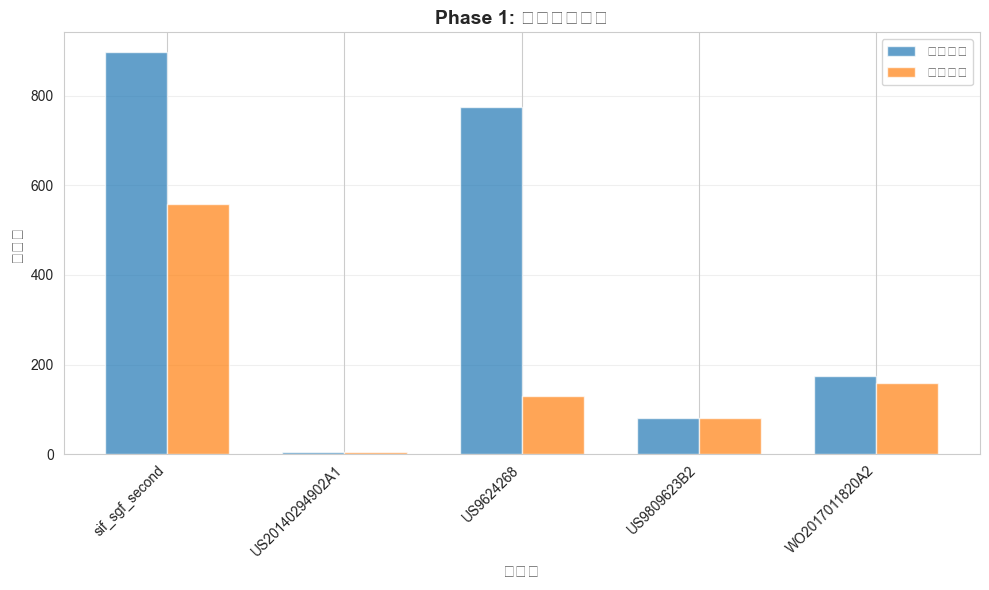

✓ 已保存: structural_features_distribution.png


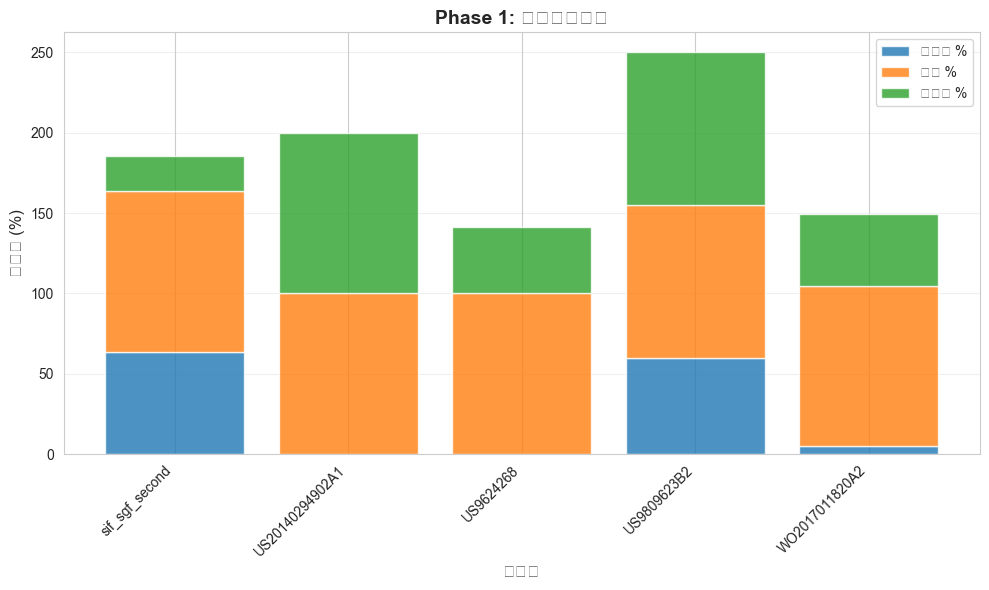


✓ Phase 1 质量验证完成！
  所有图表已保存到: outputs\figures\phase1


In [6]:
# 简化的质量验证：展示数据过滤流程和特征分布
from IPython.display import Image as IPImage, display as ipy_display

# 1. 数据过滤流程桑基图（简化版：条形图）
fig, ax = plt.subplots(figsize=(10, 6))

datasets = summary_df['file'].str.replace('_processed.csv', '').str.replace('.csv', '').tolist()
original = summary_df['original_count'].tolist()
filtered = summary_df['filtered_count'].tolist()

x = np.arange(len(datasets))
width = 0.35

ax.bar(x - width/2, original, width, label='原始样本', alpha=0.7)
ax.bar(x + width/2, filtered, width, label='保留样本', alpha=0.7)

ax.set_xlabel('数据集', fontsize=12)
ax.set_ylabel('样本数', fontsize=12)
ax.set_title('Phase 1: 数据过滤统计', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
filter_plot_path = CONFIG['figures_dir'] / 'data_filtering_summary.png'
plt.savefig(filter_plot_path, dpi=CONFIG['dpi'], bbox_inches='tight')
print(f"✓ 已保存: {filter_plot_path.name}")

if CONFIG['display_plots']:
    plt.show()
else:
    plt.close()

# 2. 结构特征分布堆叠条形图
fig, ax = plt.subplots(figsize=(10, 6))

dimer_pct = (summary_df['dimer_count'] / summary_df['filtered_count'] * 100).tolist()
cyclic_pct = (summary_df['cyclic_count'] / summary_df['filtered_count'] * 100).tolist()
disulfide_pct = (summary_df['disulfide_count'] / summary_df['filtered_count'] * 100).tolist()

x = np.arange(len(datasets))
ax.bar(x, dimer_pct, label='二聚体 %', alpha=0.8)
ax.bar(x, cyclic_pct, bottom=dimer_pct, label='环化 %', alpha=0.8)
ax.bar(x, disulfide_pct, bottom=np.array(dimer_pct) + np.array(cyclic_pct), label='二硫键 %', alpha=0.8)

ax.set_xlabel('数据集', fontsize=12)
ax.set_ylabel('百分比 (%)', fontsize=12)
ax.set_title('Phase 1: 结构特征分布', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
feature_plot_path = CONFIG['figures_dir'] / 'structural_features_distribution.png'
plt.savefig(feature_plot_path, dpi=CONFIG['dpi'], bbox_inches='tight')
print(f"✓ 已保存: {feature_plot_path.name}")

if CONFIG['display_plots']:
    plt.show()
else:
    plt.close()

print(f"\n✓ Phase 1 质量验证完成！")
print(f"  所有图表已保存到: {CONFIG['figures_dir'].relative_to(project_root)}")

## 6. 结果总结 Summary

Phase 1 数据转化已完成！

In [7]:
print("="*70)
print("Phase 1: 数据转化 - 执行完毕")
print("="*70)

print("\n📁 生成的文件:")
print(f"\n  1. 处理后的CSV ({len(list(CONFIG['processed_dir'].glob('*.csv')))} 个文件):")
for f in sorted(CONFIG['processed_dir'].glob('*_processed.csv')):
    print(f"     - {f.name}")

print(f"\n  2. 特征NPZ文件 ({len(list(CONFIG['features_dir'].glob('*.npz')))} 个文件):")
for f in sorted(CONFIG['features_dir'].glob('*.npz')):
    size_mb = f.stat().st_size / 1024 / 1024
    print(f"     - {f.name} ({size_mb:.2f} MB)")

print(f"\n  3. 验证图表 ({len(list(CONFIG['figures_dir'].glob('*.png')))} 个文件):")
for f in sorted(CONFIG['figures_dir'].glob('*.png')):
    print(f"     - {f.name}")

print("\n📊 处理统计:")
total_original = summary_df['original_count'].sum()
total_filtered = summary_df['filtered_count'].sum()
retention_rate = total_filtered / total_original * 100

print(f"  原始样本总数: {total_original:,}")
print(f"  保留样本总数: {total_filtered:,} ({retention_rate:.1f}%)")
print(f"  过滤样本数: {total_original - total_filtered:,} ({100-retention_rate:.1f}%)")
print(f"\n  二聚体样本: {summary_df['dimer_count'].sum()} ({summary_df['dimer_count'].sum()/total_filtered*100:.1f}%)")
print(f"  环化样本: {summary_df['cyclic_count'].sum()} ({summary_df['cyclic_count'].sum()/total_filtered*100:.1f}%)")
print(f"  含二硫键样本: {summary_df['disulfide_count'].sum()} ({summary_df['disulfide_count'].sum()/total_filtered*100:.1f}%)")

print(f"\n✅ 下一步: 运行 Phase2_数据可视化.ipynb")
print("="*70)

Phase 1: 数据转化 - 执行完毕

📁 生成的文件:

  1. 处理后的CSV (5 个文件):
     - sif_sgf_second_processed.csv
     - US20140294902A1_processed.csv
     - US9624268_processed.csv
     - US9809623B2_processed.csv
     - WO2017011820A2_processed.csv

  2. 特征NPZ文件 (7 个文件):
     - sif_sgf_second_cleaned.npz (0.20 MB)
     - sif_sgf_second_processed.npz (0.12 MB)
     - US20140294902A1_processed.npz (0.00 MB)
     - US9624268_cleaned.npz (0.05 MB)
     - US9624268_processed.npz (0.03 MB)
     - US9809623B2_processed.npz (0.02 MB)
     - WO2017011820A2_processed.npz (0.03 MB)

  3. 验证图表 (2 个文件):
     - data_filtering_summary.png
     - structural_features_distribution.png

📊 处理统计:
  原始样本总数: 1,931
  保留样本总数: 932 (48.3%)
  过滤样本数: 999 (51.7%)

  二聚体样本: 412 (44.2%)
  环化样本: 927 (99.5%)
  含二硫键样本: 328 (35.2%)

✅ 下一步: 运行 Phase2_数据可视化.ipynb
